In [14]:
import pandas as pd
import numpy as np
import json
from IPython.display import display

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
import scipy.stats as stats
import scipy.io
from scipy.spatial import distance as Distance
from scipy.stats import ttest_ind
from scipy.stats import binom_test

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

import random
random.seed(9001)

%matplotlib inline

## sklearn imports
# import sklearn.linear_model
# import sklearn.cross_validation
# import sklearn.tree
# import sklearn.ensemble
# import sklearn.preprocessing
# import sklearn.feature_selection
# import sklearn.pipeline
# import sklearn.grid_search

In [15]:
# subjects hard-coded
controls = str(np.arange(101,121))
subjs = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', \
        '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022']
onoffsubjs = ['011', '012', '013', '014', '015', '016', '017', '020', '021', '022']
    
onmeds = ['011_2', '012_2', '013_2', '014_2', '015_2', '016_2', '017_2', '018_2', '019_2', '020_2', '021_2', '022_2']
offmeds = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', \
           '011_1', '012_1', '013_1', '014_1', '015_1', '016_1', '017_1', '018', \
           '019', '020_1', '021_1', '022_2']

# main directory where data is stored
mainDir = '/Users/adam2392/Documents/MATLAB/Neural_Interaction_Lab_MatlabForPD/02_StepAnalysis/Processed_StepLength/'
kinectFiles = []
for file in os.listdir(mainDir):
    if file.endswith('.mat'):
        kinectFiles.append(file)

print kinectFiles

['Subj_001_Step.mat', 'Subj_002_Step.mat', 'Subj_003_Step.mat', 'Subj_005_Step.mat', 'Subj_006_Step.mat', 'Subj_007_Step.mat', 'Subj_008_Step.mat', 'Subj_009_Step.mat', 'Subj_010_Step.mat', 'Subj_011_1_Step.mat', 'Subj_011_2_Step.mat', 'Subj_012_1_Step.mat', 'Subj_012_2_Step.mat', 'Subj_013_1_Step.mat', 'Subj_013_2_Step.mat', 'Subj_014_1_Step.mat', 'Subj_014_2_Step.mat', 'Subj_015_1_Step.mat', 'Subj_015_2_Step.mat', 'Subj_016_1_Step.mat', 'Subj_016_2_Step.mat', 'Subj_017_1_Step.mat', 'Subj_017_2_Step.mat', 'Subj_018_Step.mat', 'Subj_019_Step.mat', 'Subj_020_1_Step.mat', 'Subj_020_2_Step.mat', 'Subj_021_1_Step.mat', 'Subj_021_2_Step.mat', 'Subj_022_1_Step.mat', 'Subj_022_2_Step.mat', 'Subj_103_Step.mat', 'Subj_104_Step.mat', 'Subj_105_Step.mat', 'Subj_106_Step.mat', 'Subj_107_Step.mat', 'Subj_108_Step.mat', 'Subj_109_Step.mat', 'Subj_110_Step.mat', 'Subj_112_Step.mat', 'Subj_113_Step.mat', 'Subj_114_Step.mat', 'Subj_115_Step.mat', 'Subj_117_Step.mat', 'Subj_118_Step.mat', 'Subj_119_Step

In [16]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem
    return dict

def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []            
    for sub_elem in ndarray:
        if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)
    return elem_list

def convertMatToJSON(matData, fileName):
    for key in matData.keys():
        if (type(matData[key])) is np.ndarray:
            serializedData = pickle.dumps(matData[key], protocol=0) # protocol 0 is printable ASCII
            jsonData[key] = serializedData
        else:
            jsonData[key] = matData[key]

    with contextlib.closing(bz2.BZ2File(fileName, 'wb')) as f:
        json.dump(jsonData, f)

# 1a. Organize Controls Data

In [17]:
controls = str(np.arange(101,121))

# Get all control EPARC data
kinectControldf = pd.DataFrame()
for idx, file in enumerate(kinectFiles):
    data = loadmat(mainDir + file)
    keys = data.keys()
    
    subjName = file.split('_')[1]
#     print subjName

    if subjName in controls:
        subj_key = 'Subj_' + subjName + '_Step'
        stepData = data[subj_key]

        print stepData.keys()
        stepLength = stepData['pks']
        velocity = stepData['velocity']
        cadence = stepData['cadence']
        cadence.append(np.nan)
        
        if 'hnPks' in stepData.keys():
            hnstepLength = stepData['hnPks']
            hnvelocity = stepData['hnVelocity']


            toInsertdf = pd.DataFrame({
                    'Patient': subjName,
                    'Step Length': stepLength,
                    'Velocity': velocity,
                    'Cadence': cadence,
                    'Hn Step Length': hnstepLength,
                    'Hn Velocity': hnvelocity
                })
        else:
            try:
                toInsertdf = pd.DataFrame({
                        'Patient': subjName,
                        'Step Length': stepLength,
                        'Velocity': velocity,
                        'Cadence': cadence
                    })
            except:
                toInsertdf = pd.DataFrame({
                        'Patient': subjName,
                        'Step Length': stepLength,
#                         'Velocity': velocity,
                        'Cadence': cadence
                    })
        toInsertdf.set_index('Patient')
        kinectControldf = pd.concat([kinectControldf, toInsertdf], axis=0)

display(kinectControldf.head())

['pks', 'avgVelocity', 'loc', 'timestamps', 'time', 'hnAmplitude', 'hnPks', 'hnVariance', 'hnVelocity', 'hasHeight', 'step', 'frequency', 'amplitude', 'velocity', 'stepLength', 'variance', 'hnStepLength', 'cadence', 'hnAvgVelocity']
['pks', 'avgVelocity', 'loc', 'timestamps', 'time', 'hnAmplitude', 'hnPks', 'hnVariance', 'hnVelocity', 'hasHeight', 'step', 'frequency', 'amplitude', 'velocity', 'stepLength', 'variance', 'hnStepLength', 'cadence', 'hnAvgVelocity']
['pks', 'avgVelocity', 'loc', 'timestamps', 'time', 'hnAmplitude', 'hnPks', 'hnVariance', 'hnVelocity', 'hasHeight', 'step', 'frequency', 'amplitude', 'velocity', 'stepLength', 'variance', 'hnStepLength', 'cadence', 'hnAvgVelocity']
['pks', 'avgVelocity', 'loc', 'timestamps', 'time', 'hnAmplitude', 'hnPks', 'hnVariance', 'hnVelocity', 'hasHeight', 'step', 'frequency', 'amplitude', 'velocity', 'stepLength', 'variance', 'hnStepLength', 'cadence', 'hnAvgVelocity']
['pks', 'avgVelocity', 'loc', 'timestamps', 'time', 'hnAmplitude', '

,Cadence,Hn Step Length,Hn Velocity,Patient,Step Length,Velocity
0,0.599042,0.365030,0.000000,103,0.574849,0.000000
1,0.490125,0.309346,0.824924,103,0.487159,1.299090
2,0.544584,0.360799,0.549998,103,0.568186,0.866137
3,0.599042,0.360261,1.098356,103,0.567339,1.729691
4,0.381209,0.295755,0.859751,103,0.465754,1.353937


In [18]:
print kinectControldf.shape

(1532, 6)


# 1b. Organize On Meds Kinect Data

In [19]:
# Get all control EPARC data
kinectOndf = pd.DataFrame()
for idx, file in enumerate(kinectFiles):
    data = loadmat(mainDir + file)
    keys = data.keys()
    
    subj = file.split('_')
    if subj[1] in onoffsubjs:
        subjName = subj[1] + '_' + subj[2]
    else:
        subjName = subj[1]

    if subjName in onmeds:
        subj_key = 'Subj_' + subjName + '_Step'

        stepData = data[subj_key]

        # extract data from mat file
        stepLength = stepData['pks']
        velocity = stepData['velocity']
        cadence = stepData['cadence']
        cadence.append(np.nan)
        
        if 'hnPks' in stepData.keys():
            hnstepLength = stepData['hnPks']
            hnvelocity = stepData['hnVelocity']


            toInsertdf = pd.DataFrame({
                    'Patient': subjName,
                    'Step Length': stepLength,
                    'Velocity': velocity,
                    'Cadence': cadence,
                    'Hn Step Length': hnstepLength,
                    'Hn Velocity': hnvelocity
                })
        else:
            try:
                toInsertdf = pd.DataFrame({
                        'Patient': subjName,
                        'Step Length': stepLength,
                        'Velocity': velocity,
                        'Cadence': cadence
                    })
            except:
                toInsertdf = pd.DataFrame({
                        'Patient': subjName,
                        'Step Length': stepLength,
#                         'Velocity': velocity,
                        'Cadence': cadence
                    })
        toInsertdf.set_index('Patient')
        kinectOndf = pd.concat([kinectOndf, toInsertdf], axis=0)

display(kinectOndf.head())

,Cadence,Hn Step Length,Hn Velocity,Patient,Step Length,Velocity
0,1.936922,0.185586,0.000000,011_2,0.185586,0.000000
1,22.080906,0.026135,0.030966,011_2,0.026135,0.030966
2,0.658553,0.379274,0.039665,011_2,0.379274,0.039665
3,0.697292,0.536127,1.805142,011_2,0.536127,1.805142
4,0.619815,0.455263,1.532873,011_2,0.455263,1.532873


In [20]:
display(np.unique(kinectOndf['Patient']))

array(['011_2', '012_2', '013_2', '014_2', '015_2', '016_2', '017_2',
       '020_2', '021_2', '022_2'], dtype=object)

# 1c. Organize Off Meds Data

In [21]:
# Get all control EPARC data
kinectOffdf = pd.DataFrame()
for idx, file in enumerate(kinectFiles):
    data = loadmat(mainDir + file)
    keys = data.keys()
    
    subj = file.split('_')
    if subj[1] in onoffsubjs:
        subjName = subj[1] + '_' + subj[2]
    else:
        subjName = subj[1]

    if subjName in offmeds:
        subj_key = 'Subj_' + subjName + '_Step'       
        stepData = data[subj_key]

        # extract the data from mat file
        stepLength = stepData['pks']
        velocity = stepData['velocity']
        cadence = stepData['cadence']
        cadence.append(np.nan)
        
        # put in height normalized data if available
        if 'hnPks' in stepData.keys():
            hnstepLength = stepData['hnPks']
            hnvelocity = stepData['hnVelocity']


            toInsertdf = pd.DataFrame({
                    'Patient': subjName,
                    'Step Length': stepLength,
                    'Velocity': velocity,
                    'Cadence': cadence,
                    'Hn Step Length': hnstepLength,
                    'Hn Velocity': hnvelocity
                })
        else:
            try:
                toInsertdf = pd.DataFrame({
                        'Patient': subjName,
                        'Step Length': stepLength,
                        'Velocity': velocity,
                        'Cadence': cadence
                    })
            except:
                toInsertdf = pd.DataFrame({
                        'Patient': subjName,
                        'Step Length': stepLength,
#                         'Velocity': velocity,
                        'Cadence': cadence
                    })
        toInsertdf.set_index('Patient')
        kinectOffdf = pd.concat([kinectOffdf, toInsertdf], axis=0)
        
display(kinectOffdf.head())

,Cadence,Hn Step Length,Hn Velocity,Patient,Step Length,Velocity
0,1.048966,0.003300,0.000000,001,0.005952,0.000000
1,1.525769,0.074965,0.064848,001,0.135191,0.116947
2,0.635737,0.166328,0.121054,001,0.299957,0.218309
3,0.476803,0.148362,0.278353,001,0.267557,0.501982
4,0.413229,0.180594,0.684069,001,0.325684,1.233651


In [22]:
display(np.unique(kinectOffdf['Patient']))
kinectOffdf = kinectOffdf[kinectOffdf['Patient'] != '022_2']
display(np.unique(kinectOffdf['Patient']))

array(['001', '002', '003', '005', '006', '007', '008', '009', '010',
       '011_1', '012_1', '013_1', '014_1', '015_1', '016_1', '017_1',
       '018', '019', '020_1', '021_1', '022_2'], dtype=object)

array(['001', '002', '003', '005', '006', '007', '008', '009', '010',
       '011_1', '012_1', '013_1', '014_1', '015_1', '016_1', '017_1',
       '018', '019', '020_1', '021_1'], dtype=object)

# 2. Save Control, Off, On DFs

In [23]:
# map all <number>_1, or 2 to <number>
di = {'011_1': '011', '012_1': '012', '013_1':'013', '014_1':'014', '015_1':'015','016_1':'016','017_1':'017',\
     '020_1': '020', '021_1':'021', '022_1':'022',\
     '011_2': '011', '012_2': '012', '013_2':'013', '014_2':'014', '015_2':'015','016_2':'016','017_2':'017',\
     '020_2': '020', '021_2':'021', '022_2':'022'}

kinectOndf.replace({'Patient': di}, inplace=True)
kinectOffdf.replace({'Patient': di}, inplace=True)

display(np.unique(kinectOffdf['Patient']))
display(np.unique(kinectOndf['Patient']))

array(['001', '002', '003', '005', '006', '007', '008', '009', '010',
       '011', '012', '013', '014', '015', '016', '017', '018', '019',
       '020', '021'], dtype=object)

array(['011', '012', '013', '014', '015', '016', '017', '020', '021', '022'], dtype=object)

In [24]:
mainDir = '/Users/adam2392/Documents/MATLAB/Neural_Interaction_Lab_MatlabForPD/notebooks/processed data/'

# save each preprocessed df as a pickle file
onFileName = 'kinectDataOnMeds.pkl'
offFileName = 'kinectDataOffMeds.pkl'
controlFileName = 'kinectDataControls.pkl'

kinectOndf.to_pickle(mainDir + onFileName)
kinectOffdf.to_pickle(mainDir + offFileName)
kinectControldf.to_pickle(mainDir + controlFileName)

# 3. Summarize Results For Each Group

Independent T-test between On and Off Meds Step Length (P-Value):  1.05133509388e-08
Independent T-test between On and Off Meds Velocity (P-Value):  4.63826912483e-11
Independent T-test between On and Off Meds Cadence (P-Value):  0.958080643753
Independent T-test between On and Off Meds HN Step Length (P-Value):  6.28292031058e-09
Independent T-test between On and Off Meds HN Velocity (P-Value):  4.92595433358e-11


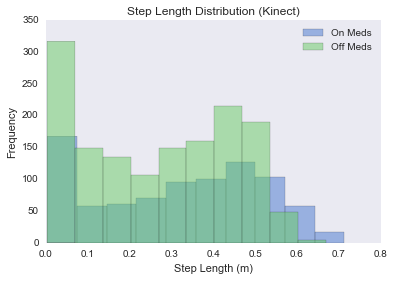

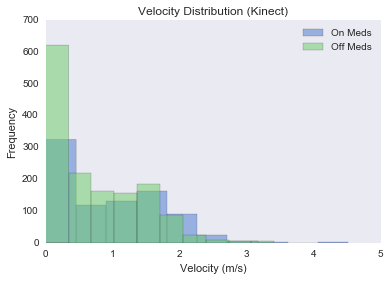

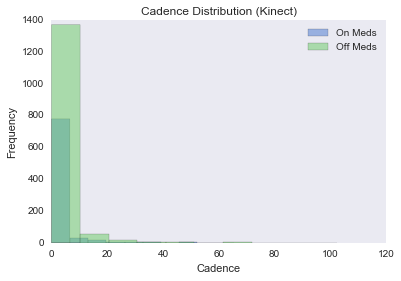

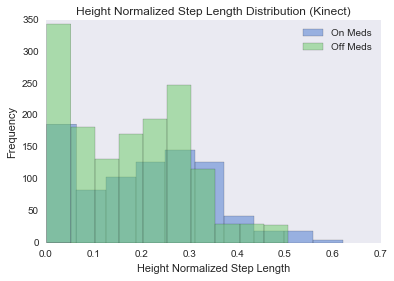

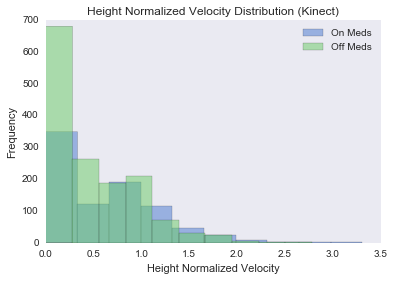

In [25]:
# Step Length
onsteplength = kinectOndf['Step Length'].dropna()
offsteplength = kinectOffdf['Step Length'].dropna()
onvsoff_steplength = ttest_ind(a=onsteplength, b=offsteplength)

fig = plt.figure()
onsteplength.plot.hist(alpha=0.5)
offsteplength.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Step Length (m)')
plt.title('Step Length Distribution (Kinect)')
plt.legend(['On Meds', 'Off Meds'])

print "Independent T-test between On and Off Meds Step Length (P-Value): ", onvsoff_steplength[1]

# Velocity
onvelocity = kinectOndf['Velocity'].dropna()
offvelocity = kinectOffdf['Velocity'].dropna()
onvsoff_velocity = ttest_ind(a=onvelocity, b=offvelocity)

fig = plt.figure()
onvelocity.plot.hist(alpha=0.5)
offvelocity.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Velocity (m/s)')
plt.title('Velocity Distribution (Kinect)')
plt.legend(['On Meds', 'Off Meds'])

print "Independent T-test between On and Off Meds Velocity (P-Value): ", onvsoff_velocity[1]

# Cadence
oncadence = kinectOndf['Cadence'].dropna()
offcadence = kinectOffdf['Cadence'].dropna()
onvsoff_cadence = ttest_ind(a=oncadence, b=offcadence)

fig = plt.figure()
oncadence.plot.hist(alpha=0.5)
offcadence.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Cadence')
plt.title('Cadence Distribution (Kinect)')
plt.legend(['On Meds', 'Off Meds'])

print "Independent T-test between On and Off Meds Cadence (P-Value): ", onvsoff_cadence[1]

## Height Normalized
# HN Step Length
onhnsteplength = kinectOndf['Hn Step Length'].dropna()
offhnsteplength = kinectOffdf['Hn Step Length'].dropna()
onvsoff_hnsteplength = ttest_ind(a=onhnsteplength, b=offhnsteplength)

fig = plt.figure()
onhnsteplength.plot.hist(alpha=0.5)
offhnsteplength.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Height Normalized Step Length')
plt.title('Height Normalized Step Length Distribution (Kinect)')
plt.legend(['On Meds', 'Off Meds'])

print "Independent T-test between On and Off Meds HN Step Length (P-Value): ", onvsoff_hnsteplength[1]

# HN Velocity
onhnvelocity = kinectOndf['Hn Velocity'].dropna()
offhnvelocity = kinectOffdf['Hn Velocity'].dropna()
onvsoff_hnvelocity = ttest_ind(a=onhnvelocity, b=offhnvelocity)

fig = plt.figure()
onhnvelocity.plot.hist(alpha=0.5)
offhnvelocity.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Height Normalized Velocity')
plt.title('Height Normalized Velocity Distribution (Kinect)')
plt.legend(['On Meds', 'Off Meds'])

print "Independent T-test between On and Off Meds HN Velocity (P-Value): ", onvsoff_hnvelocity[1]

### Control Vs Off

Independent T-test between Ccontroltrol and Off Meds Step Length (P-Value):  0.00374187963737
Independent T-test between Ccontroltrol and Off Meds Velocity (P-Value):  0.00197487448289
Independent T-test between Ccontroltrol and Off Meds Cadence (P-Value):  7.16495289547e-05
Independent T-test between Ccontroltrol and Off Meds HN Step Length (P-Value):  0.966548226884
Independent T-test between Ccontroltrol and Off Meds HN Velocity (P-Value):  0.769530734723


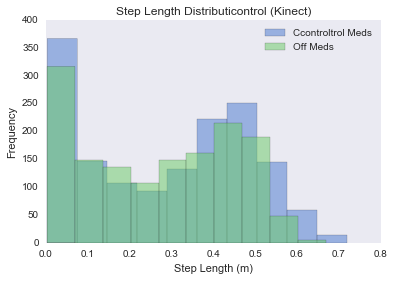

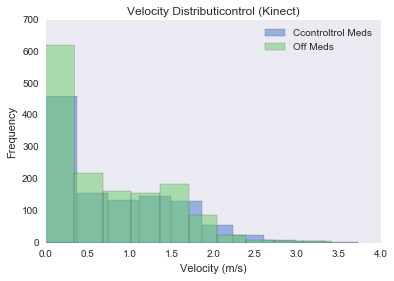

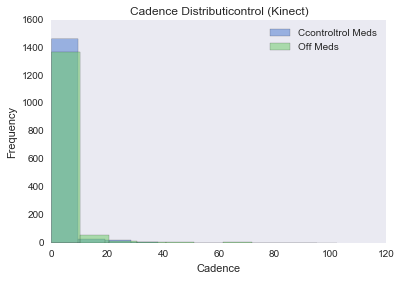

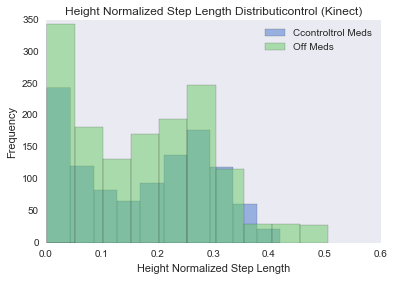

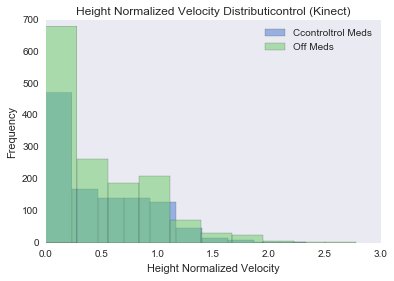

In [26]:
# Step Length
controlsteplength = kinectControldf['Step Length'].dropna()
offsteplength = kinectOffdf['Step Length'].dropna()
controlvsoff_steplength = ttest_ind(a=controlsteplength, b=offsteplength)

fig = plt.figure()
controlsteplength.plot.hist(alpha=0.5)
offsteplength.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Step Length (m)')
plt.title('Step Length Distributicontrol (Kinect)')
plt.legend(['Ccontroltrol Meds', 'Off Meds'])

print "Independent T-test between Ccontroltrol and Off Meds Step Length (P-Value): ", controlvsoff_steplength[1]

# Velocity
controlvelocity = kinectControldf['Velocity'].dropna()
offvelocity = kinectOffdf['Velocity'].dropna()
controlvsoff_velocity = ttest_ind(a=controlvelocity, b=offvelocity)

fig = plt.figure()
controlvelocity.plot.hist(alpha=0.5)
offvelocity.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Velocity (m/s)')
plt.title('Velocity Distributicontrol (Kinect)')
plt.legend(['Ccontroltrol Meds', 'Off Meds'])

print "Independent T-test between Ccontroltrol and Off Meds Velocity (P-Value): ", controlvsoff_velocity[1]

# Cadence
controlcadence = kinectControldf['Cadence'].dropna()
offcadence = kinectOffdf['Cadence'].dropna()
controlvsoff_cadence = ttest_ind(a=controlcadence, b=offcadence)

fig = plt.figure()
controlcadence.plot.hist(alpha=0.5)
offcadence.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Cadence')
plt.title('Cadence Distributicontrol (Kinect)')
plt.legend(['Ccontroltrol Meds', 'Off Meds'])

print "Independent T-test between Ccontroltrol and Off Meds Cadence (P-Value): ", controlvsoff_cadence[1]

## Height Normalized
# HN Step Length
controlhnsteplength = kinectControldf['Hn Step Length'].dropna()
offhnsteplength = kinectOffdf['Hn Step Length'].dropna()
controlvsoff_hnsteplength = ttest_ind(a=controlhnsteplength, b=offhnsteplength)

fig = plt.figure()
controlhnsteplength.plot.hist(alpha=0.5)
offhnsteplength.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Height Normalized Step Length')
plt.title('Height Normalized Step Length Distributicontrol (Kinect)')
plt.legend(['Ccontroltrol Meds', 'Off Meds'])

print "Independent T-test between Ccontroltrol and Off Meds HN Step Length (P-Value): ", controlvsoff_hnsteplength[1]

# HN Velocity
controlhnvelocity = kinectControldf['Hn Velocity'].dropna()
offhnvelocity = kinectOffdf['Hn Velocity'].dropna()
controlvsoff_hnvelocity = ttest_ind(a=controlhnvelocity, b=offhnvelocity)

fig = plt.figure()
controlhnvelocity.plot.hist(alpha=0.5)
offhnvelocity.plot.hist(alpha=0.5)
plt.grid(False)
plt.xlabel('Height Normalized Velocity')
plt.title('Height Normalized Velocity Distributicontrol (Kinect)')
plt.legend(['Ccontroltrol Meds', 'Off Meds'])

print "Independent T-test between Ccontroltrol and Off Meds HN Velocity (P-Value): ", controlvsoff_hnvelocity[1]


In [27]:
print "Summary for each group"
print "Velocity of off meds: ", np.mean(offvelocity), ' +/- ', np.std(offvelocity)
print "Step Length of off meds: ", np.mean(offsteplength), ' +/- ', np.std(offsteplength)
print "Cadence of off meds: ", np.mean(offcadence), ' +/- ', np.std(offcadence)
print "HN Velocity of off meds: ", np.mean(offhnvelocity), ' +/- ', np.std(offhnvelocity)
print "HN Step Length of off meds: ", np.mean(offhnsteplength), ' +/- ', np.std(offhnsteplength)

print "\n"
print "Velocity of on meds: ", np.mean(onvelocity), ' +/- ', np.std(onvelocity)
print "Step Length of on meds: ", np.mean(onsteplength), ' +/- ', np.std(onsteplength)
print "Cadence of on meds: ", np.mean(oncadence), ' +/- ', np.std(oncadence)
print "HN Velocity of on meds: ", np.mean(onhnvelocity), ' +/- ', np.std(onhnvelocity)
print "HN Step Length of on meds: ", np.mean(onhnsteplength), ' +/- ', np.std(onhnsteplength)

print "\n"
print "Velocity of control: ", np.mean(controlvelocity), ' +/- ', np.std(controlvelocity)
print "Step Length of control: ", np.mean(controlsteplength), ' +/- ', np.std(controlsteplength)
print "Cadence of control: ", np.mean(controlcadence), ' +/- ', np.std(controlcadence)
print "HN Velocity of control: ", np.mean(controlhnvelocity), ' +/- ', np.std(controlhnvelocity)
print "HN Step Length of control: ", np.mean(controlhnsteplength), ' +/- ', np.std(controlhnsteplength)

Summary for each group
Velocity of off meds:  0.708809402247  +/-  0.672586109834
Step Length of off meds:  0.268684350886  +/-  0.178247876431
Cadence of off meds:  2.47695032089  +/-  6.26503936559
HN Velocity of off meds:  0.465229924615  +/-  0.462193928202
HN Step Length of off meds:  0.175128327758  +/-  0.122746319412


Velocity of on meds:  0.911548312208  +/-  0.776695183709
Step Length of on meds:  0.31449938649  +/-  0.197223248158
Cadence of on meds:  2.49080776364  +/-  5.77628154193
HN Velocity of on meds:  0.605192079508  +/-  0.541033192936
HN Step Length of on meds:  0.207436669008  +/-  0.138620069033


Velocity of control:  0.794349215675  +/-  0.727343073618
Step Length of control:  0.288516303501  +/-  0.195447075202
Cadence of control:  1.65700204736  +/-  4.90967756927
HN Velocity of control:  0.47046006537  +/-  0.434272937247
HN Step Length of control:  0.17532864696  +/-  0.117487201057
